<a href="https://colab.research.google.com/github/Ashutosh-Bahet/Commidty/blob/main/bert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch

if torch.cuda.is_available():
  device = torch.device('cuda')

  print('there are %d GPU(s) available.' % torch.cuda.device_count())

  print('we will use the GPU: ', torch.cuda.get_device_name(0))

else:
  print("No GPU available, using the CPU instead")
  device = torch.device("cpu")

there are 1 GPU(s) available.
we will use the GPU:  Tesla T4


In [ ]:
import torch

if torch.cuda.is_available():
  device = torch.device('cuda')

  print('there are %d GPU(s) available.' % torch.cuda.device_count())

  print('we will use the GPU: ', torch.cuda.get_device_name(0))

else:
  print("No GPU available, using the CPU instead")
  device = torch.device("cpu")
import pandas as pd

df = pd.read_csv('/content/gold-dataset-sinha-khandait.csv', usecols=["Price Sentiment", "News"])
df.rename(columns = {'News':'news', 'Price Sentiment':'sentiment'}, inplace = True)
df.info()
df = df[(df.sentiment != "none")]
df = df.replace({'sentiment' : {'negative':0, 'neutral':1, 'positive':2}})
df.head()
import seaborn as sns
import matplotlib.pyplot as plt

sentiment = df['sentiment'].value_counts()
plt.figure(figsize=(12,4))
sns.barplot(x=sentiment.index, y=sentiment.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('sentiment', fontsize=12)
plt.xticks(rotation=90)
plt.show();
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from bs4 import BeautifulSoup
import contractions
import tqdm

def clean_text(text):
    # Remove HTML tags
    text = BeautifulSoup(text, "html.parser").get_text()

    # Fix contractions (English only)
    text = contractions.fix(text)

    # Strip whitespace
    text = text.strip()

    return text


def pre_process_corpus(docs):
    norm_docs = []
    for doc in tqdm.tqdm(docs):
        cleaned = clean_text(doc)
        norm_docs.append(cleaned)
    return norm_docs
import nltk
nltk.download('punkt_tab')
df.news = pre_process_corpus(df.news)
sentences = df.news.values
labels = df.sentiment.values
from transformers import BertTokenizer

print("load BERT Tokenizer")
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_cased = True)
encoding = tokenizer(
    sentences.tolist(),
    max_length=256,
    padding='max_length',
    truncation=True,
    return_attention_mask=True,
    return_tensors='pt'
)

input_ids = encoding['input_ids']
attention_mask = encoding['attention_mask']
print('Original:', sentences[0])
print('Token IDS:', input_ids[0])
print('Max Sentence length', max([len(sen) for sen in input_ids]))
input_ids = encoding['input_ids']
attention_mask = encoding['attention_mask']
from sklearn.model_selection import train_test_split

# 1. Train / Test split
train_input, test_input, train_mask, test_mask, train_labels, test_labels = train_test_split(
    input_ids, attention_mask, labels,
    test_size=0.2,
    random_state=42,
    stratify=labels
)

# 2. Train / Validation split
train_input, val_input, train_mask, val_mask, train_labels, val_labels = train_test_split(
    train_input, train_mask, train_labels,
    test_size=0.1,
    random_state=42,
    stratify=train_labels
)
import numpy as np

print('---Train---')
print('input: ', train_input.shape)
print('label: ', train_labels.shape)
print('mask: ', train_mask.shape)

print('---Validation---')
print('input: ', val_input.shape)
print('label: ', val_labels.shape)
print('mask: ', val_mask.shape)

print('---Test---')
print('input: ', test_input.shape)
print('label: ', test_labels.shape)
print('mask: ', test_mask.shape)
import torch

train_input = torch.tensor(train_input)
train_labels = torch.tensor(train_labels)
train_mask   = torch.tensor(train_mask)

val_input = torch.tensor(val_input)
val_labels = torch.tensor(val_labels)
val_mask   = torch.tensor(val_mask)

test_input = torch.tensor(test_input)
test_labels = torch.tensor(test_labels)
test_mask   = torch.tensor(test_mask)
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

batch_size = 10
train_data = TensorDataset(train_input, train_mask, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
val_data = TensorDataset(val_input, val_mask, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)
test_data = TensorDataset(test_input, test_mask, test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)
from transformers import BertForSequenceClassification,get_linear_schedule_with_warmup
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=3)
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)
epochs = 3
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten
def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))
import time
import datetime
model.to(device)
gradient_accumulation_steps = 4

for epoch_i in range(epochs):
    print(f"Epoch {epoch_i + 1}/{epochs}")
    print("Training...")

    t0 = time.time()
    total_loss = 0
    model.train()

    for step, batch in enumerate(train_dataloader):

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        outputs = model(
            b_input_ids,
            attention_mask=b_input_mask,
            labels=b_labels
        )

        loss = outputs.loss
        loss = loss / gradient_accumulation_steps
        total_loss += loss.item()

        loss.backward()

        if (step + 1) % gradient_accumulation_steps == 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()
            model.zero_grad()

    avg_train_loss = total_loss / len(train_dataloader)
    print(f"Average training loss: {avg_train_loss:.4f}")
    print(f"Training took: {format_time(time.time() - t0)}")

    # ------------------------------
    # Validation
    # ------------------------------
    print("Running Validation...")
    t0 = time.time()
    model.eval()

    eval_accuracy = 0
    eval_loss = 0
    nb_eval_steps = 0

    for batch in val_dataloader:

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        with torch.no_grad():
            outputs = model(
                b_input_ids,
                attention_mask=b_input_mask,
                labels=b_labels
            )

        loss = outputs.loss
        logits = outputs.logits

        eval_loss += loss.item()

        preds = logits.detach().cpu().numpy()
        label_ids = b_labels.to("cpu").numpy()

        eval_accuracy += flat_accuracy(preds, label_ids)
        nb_eval_steps += 1

    print(f"Validation Loss: {eval_loss / nb_eval_steps:.4f}")
    print(f"Validation Accuracy: {eval_accuracy / nb_eval_steps:.4f}")
    print(f"Validation took: {format_time(time.time() - t0)}\n")

print("Training complete!")
model.eval()

all_preds = []
all_labels = []

for batch in test_dataloader:

    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_labels = batch[2].to(device)

    with torch.no_grad():
        outputs = model(
            b_input_ids,
            attention_mask=b_input_mask
        )

    logits = outputs.logits
    preds = torch.argmax(logits, dim=1)

    all_preds.extend(preds.cpu().numpy())
    all_labels.extend(b_labels.cpu().numpy())
    from sklearn.metrics import matthews_corrcoef

mcc = matthews_corrcoef(all_labels, all_preds)
print("MCC:", mcc)



there are 1 GPU(s) available.
we will use the GPU:  Tesla T4


In [ ]:
import torch

if torch.cuda.is_available():
  device = torch.device('cuda')

  print('there are %d GPU(s) available.' % torch.cuda.device_count())

  print('we will use the GPU: ', torch.cuda.get_device_name(0))

else:
  print("No GPU available, using the CPU instead")
  device = torch.device("cpu")
  !pip install contractions

import warnings
warnings.filterwarnings('ignore')
import pandas as pd

df = pd.read_csv('/content/gold-dataset-sinha-khandait.csv', usecols=["Price Sentiment", "News"])
df.rename(columns = {'News':'news', 'Price Sentiment':'sentiment'}, inplace = True)
df.info()
df = df[(df.sentiment != "none")]
df = df.replace({'sentiment' : {'negative':0, 'neutral':1, 'positive':2}})
df.head()
import seaborn as sns
import matplotlib.pyplot as plt

sentiment = df['sentiment'].value_counts()
plt.figure(figsize=(12,4))
sns.barplot(x=sentiment.index, y=sentiment.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('sentiment', fontsize=12)
plt.xticks(rotation=90)
plt.show()
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from bs4 import BeautifulSoup
import re
import nltk
import tqdm
import unicodedata
import contractions

from nltk.tokenize import word_tokenize


def strip_html_tags(text):
  soup = BeautifulSoup(text, "html.parser")
  [s.extract() for s in soup(['iframe', 'script'])]
  stripped_text = soup.get_text()
  stripped_text = re.sub(r'[\r|\n|\r\n]+', '\n', stripped_text)
  return stripped_text

def remove_accented_chars(text):
  text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
  return text

def stopwords_removal(words):
    list_stopwords = nltk.corpus.stopwords.words('english')
    return [word for word in words if word not in list_stopwords]
def pre_process_corpus(docs):
  norm_docs = []
  for doc in tqdm.tqdm(docs):
    #case folding
    doc = doc.lower()
    #remove special characters\whitespaces
    doc = strip_html_tags(doc)
    doc = doc.translate(doc.maketrans("\n\t\r", "   "))
    doc = remove_accented_chars(doc)
    doc = contractions.fix(doc)
    doc = re.sub(r'[^a-zA-Z0-9\s]', '', doc, re.I|re.A)
    doc = re.sub(' +', ' ', doc)
    doc = doc.strip()
    #tokenize
    doc = word_tokenize(doc)
    #filtering
    doc = stopwords_removal(doc)
    norm_docs.append(doc)

  norm_docs = [" ".join(word) for word in norm_docs]
  return norm_docs
  sentences = df.news.values
labels = df.sentiment.values
from transformers import BertTokenizer

print("load BERT Tokenizer")
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-uncased', do_lower_cased = True)
print('Original:', sentences[0])
print('Tokenized:', tokenizer.tokenize(sentences[0]))
print('Token IDS:', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[0])))
input_ids = []
for sent in sentences:
    encoded_sent = tokenizer.encode(sent, add_special_tokens = True)
    input_ids.append(encoded_sent)

print('Original:', sentences[0])
print('Token IDS:', input_ids[0])
from tensorflow.keras.preprocessing.sequence import pad_sequences
print('Max Sentence length', max([len(sen) for sen in input_ids]))
MAX_LEN = 256

print('padding/truncating all sentences to %d values' % MAX_LEN)
print('padding token:"{:}", ID: {:}'.format(tokenizer.pad_token, tokenizer.pad_token_id))

input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype='long', value=0, truncating='post', padding='post')

print('Done')
attention_mask = []

for sent in input_ids:
    att_mask = [int(token_id > 0) for token_id in sent]

    attention_mask.append(att_mask)
from sklearn.model_selection import train_test_split

train_input, test_input, train_labels, test_labels = train_test_split(input_ids, labels, random_state=42, test_size=0.35)
train_mask, test_mask, _, _ = train_test_split(attention_mask, labels, random_state=42, test_size=0.35)

train_input, validation_input, train_labels, validation_labels = train_test_split(train_input, train_labels, random_state=42, test_size=0.35)
train_mask, validation_mask, _, _ = train_test_split(train_mask, train_mask, random_state=42, test_size=0.35)
import numpy as np

print('---Train---')
print('input: ', train_input.shape)
print('label: ', train_labels.shape)
print('mask: ', np.array(train_mask).shape)

print('---Validation---')
print('input: ', validation_input.shape)
print('label: ', validation_labels.shape)
print('mask: ', np.array(validation_mask).shape)

print('---Test---')
print('input: ', test_input.shape)
print('label: ', test_labels.shape)
print('mask: ', np.array(test_mask).shape)
import torch
train_input = torch.tensor(train_input)
train_labels = torch.tensor(train_labels)
train_mask = torch.tensor(train_mask)

validation_input = torch.tensor(validation_input)
validation_labels = torch.tensor(validation_labels)
validation_mask = torch.tensor(validation_mask)

test_input = torch.tensor(test_input)
test_labels = torch.tensor(test_labels)
test_mask = torch.tensor(test_mask)
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

batch_size = 10

train_data = TensorDataset(train_input, train_mask, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_input, validation_mask, validation_labels)
validation_sampler = RandomSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

test_data = TensorDataset(test_input, test_mask, test_labels)
test_sampler = RandomSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)
from transformers import BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
model = BertForSequenceClassification.from_pretrained("bert-base-multilingual-uncased", num_labels=3)
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)
epochs = 3
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)
gradient_accumulation_steps = 4

for epoch_i in range(epochs):
    print(f"Epoch {epoch_i + 1} / {epochs}")
    print("Training...")

    t0 = time.time()
    total_loss = 0
    model.train()

    for step, batch in enumerate(train_dataloader):
        if step % 40 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print(f"Batch {step} of {len(train_dataloader)}. Elapsed: {elapsed}")

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()

        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        loss = outputs[0]
        loss = loss / gradient_accumulation_steps  # Normalize loss for accumulation
        total_loss += loss.item()

        loss.backward()
        if (step + 1) % gradient_accumulation_steps == 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()
            model.zero_grad()

    avg_train_loss = total_loss / len(train_dataloader)
    print(f"Average training loss: {avg_train_loss:.2f}")
    print(f"Training epoch took: {format_time(time.time() - t0)}")

    print("Running Validation...")
    t0 = time.time()
    model.eval()

    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    for batch in validation_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        with torch.no_grad():
            outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

        logits = outputs[0]
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        eval_accuracy += tmp_eval_accuracy
        nb_eval_steps += 1

    print(f"Accuracy: {eval_accuracy / nb_eval_steps:.2f}")
    print(f"Validation took: {format_time(time.time() - t0)}")

print("Training complete!")


In [ ]:
!pip install contractions

import warnings
warnings.filterwarnings('ignore')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.1/345.1 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 11.5 MB/s eta 0:00:00


In [ ]:
import pandas as pd

df = pd.read_csv('/content/gold-dataset-sinha-khandait.csv', usecols=["Price Sentiment", "News"])
df.rename(columns = {'News':'news', 'Price Sentiment':'sentiment'}, inplace = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10570 entries, 0 to 10569
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   news       10570 non-null  object
 1   sentiment  10570 non-null  object
dtypes: object(2)
memory usage: 165.3+ KB


In [ ]:
df = df[(df.sentiment != "none")]
df = df.replace({'sentiment' : {'negative':0, 'neutral':1, 'positive':2}})
df.head()

,news,sentiment
0,"april gold down 20 cents to settle at $1,116.1...",0
1,gold suffers third straight daily decline,0
2,Gold futures edge up after two-session decline,2
4,"Gold snaps three-day rally as Trump, lawmakers...",0
5,"Dec. gold climbs $9.40, or 0.7%, to settle at ...",2


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8602 entries, 0 to 10569
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   news       8602 non-null   object
 1   sentiment  8602 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 201.6+ KB


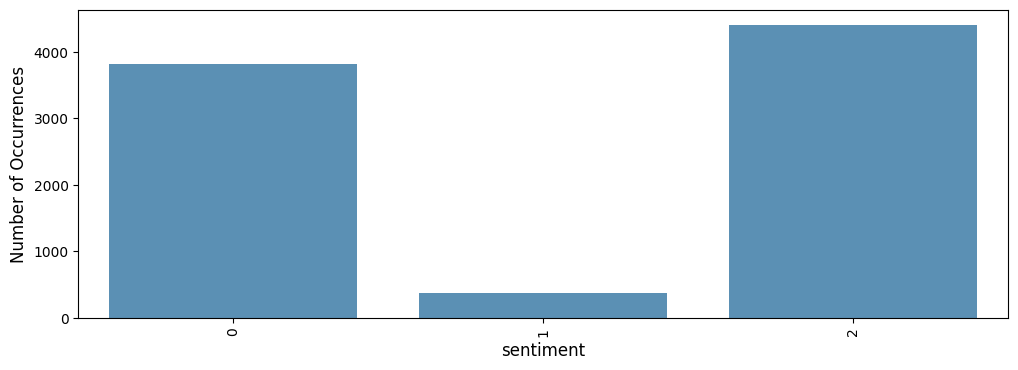

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sentiment = df['sentiment'].value_counts()
plt.figure(figsize=(12,4))
sns.barplot(x=sentiment.index, y=sentiment.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('sentiment', fontsize=12)
plt.xticks(rotation=90)
plt.show();

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
from bs4 import BeautifulSoup
import contractions
import tqdm

def clean_text(text):
    # Remove HTML tags
    text = BeautifulSoup(text, "html.parser").get_text()

    # Fix contractions (English only)
    text = contractions.fix(text)

    # Strip whitespace
    text = text.strip()

    return text


def pre_process_corpus(docs):
    norm_docs = []
    for doc in tqdm.tqdm(docs):
        cleaned = clean_text(doc)
        norm_docs.append(cleaned)
    return norm_docs


In [ ]:
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
df.news = pre_process_corpus(df.news)

100%|██████████| 8602/8602 [00:00<00:00, 16664.66it/s]


In [ ]:
df.head()

,news,sentiment
0,"april gold down 20 cents to settle at $1,116.1...",0
1,gold suffers third straight daily decline,0
2,Gold futures edge up after two-session decline,2
4,"Gold snaps three-day rally as Trump, lawmakers...",0
5,"December gold climbs $9.40, or 0.7%, to settle...",2


In [ ]:
sentences = df.news.values
labels = df.sentiment.values

In [ ]:
from transformers import BertTokenizer

print("load BERT Tokenizer")
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_cased = True)

load BERT Tokenizer


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
encoding = tokenizer(
    sentences.tolist(),
    max_length=256,
    padding='max_length',
    truncation=True,
    return_attention_mask=True,
    return_tensors='pt'
)

input_ids = encoding['input_ids']
attention_mask = encoding['attention_mask']

In [ ]:
print('Original:', sentences[0])
print('Token IDS:', input_ids[0])

Original: april gold down 20 cents to settle at $1,116.10/oz
Token IDS: tensor([  101,  2258,  2751,  2091,  2322, 16653,  2000,  7392,  2012,  1002,
         1015,  1010, 12904,  1012,  2184,  1013, 11472,   102,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,

In [ ]:
print('Max Sentence length', max([len(sen) for sen in input_ids]))

Max Sentence length 256


In [ ]:
input_ids = encoding['input_ids']
attention_mask = encoding['attention_mask']

In [ ]:
from sklearn.model_selection import train_test_split

# 1. Train / Test split
train_input, test_input, train_mask, test_mask, train_labels, test_labels = train_test_split(
    input_ids, attention_mask, labels,
    test_size=0.2,
    random_state=42,
    stratify=labels
)

# 2. Train / Validation split
train_input, val_input, train_mask, val_mask, train_labels, val_labels = train_test_split(
    train_input, train_mask, train_labels,
    test_size=0.1,
    random_state=42,
    stratify=train_labels
)


In [ ]:
import numpy as np

print('---Train---')
print('input: ', train_input.shape)
print('label: ', train_labels.shape)
print('mask: ', train_mask.shape)

print('---Validation---')
print('input: ', val_input.shape)
print('label: ', val_labels.shape)
print('mask: ', val_mask.shape)

print('---Test---')
print('input: ', test_input.shape)
print('label: ', test_labels.shape)
print('mask: ', test_mask.shape)


---Train---
input:  torch.Size([6192, 256])
label:  (6192,)
mask:  torch.Size([6192, 256])
---Validation---
input:  torch.Size([689, 256])
label:  (689,)
mask:  torch.Size([689, 256])
---Test---
input:  torch.Size([1721, 256])
label:  (1721,)
mask:  torch.Size([1721, 256])


In [ ]:
import torch

train_input = torch.tensor(train_input)
train_labels = torch.tensor(train_labels)
train_mask   = torch.tensor(train_mask)

val_input = torch.tensor(val_input)
val_labels = torch.tensor(val_labels)
val_mask   = torch.tensor(val_mask)

test_input = torch.tensor(test_input)
test_labels = torch.tensor(test_labels)
test_mask   = torch.tensor(test_mask)


In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

batch_size = 10
train_data = TensorDataset(train_input, train_mask, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
val_data = TensorDataset(val_input, val_mask, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)
test_data = TensorDataset(test_input, test_mask, test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)


In [ ]:
from transformers import BertForSequenceClassification,get_linear_schedule_with_warmup
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=3)


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from torch.optim import AdamW
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)
epochs = 3
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

In [ ]:
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
import time
import datetime
model.to(device)
gradient_accumulation_steps = 4

for epoch_i in range(epochs):
    print(f"Epoch {epoch_i + 1}/{epochs}")
    print("Training...")

    t0 = time.time()
    total_loss = 0
    model.train()

    for step, batch in enumerate(train_dataloader):

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        outputs = model(
            b_input_ids,
            attention_mask=b_input_mask,
            labels=b_labels
        )

        loss = outputs.loss
        loss = loss / gradient_accumulation_steps
        total_loss += loss.item()

        loss.backward()

        if (step + 1) % gradient_accumulation_steps == 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()
            model.zero_grad()

    avg_train_loss = total_loss / len(train_dataloader)
    print(f"Average training loss: {avg_train_loss:.4f}")
    print(f"Training took: {format_time(time.time() - t0)}")

    # ------------------------------
    # Validation
    # ------------------------------
    print("Running Validation...")
    t0 = time.time()
    model.eval()

    eval_accuracy = 0
    eval_loss = 0
    nb_eval_steps = 0

    for batch in val_dataloader:

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        with torch.no_grad():
            outputs = model(
                b_input_ids,
                attention_mask=b_input_mask,
                labels=b_labels
            )

        loss = outputs.loss
        logits = outputs.logits

        eval_loss += loss.item()

        preds = logits.detach().cpu().numpy()
        label_ids = b_labels.to("cpu").numpy()

        eval_accuracy += flat_accuracy(preds, label_ids)
        nb_eval_steps += 1

    print(f"Validation Loss: {eval_loss / nb_eval_steps:.4f}")
    print(f"Validation Accuracy: {eval_accuracy / nb_eval_steps:.4f}")
    print(f"Validation took: {format_time(time.time() - t0)}\n")

print("Training complete!")


Epoch 1/3
Training...
Average training loss: 0.1091
Training took: 0:04:06
Running Validation...
Validation Loss: 0.2217
Validation Accuracy: 0.9319
Validation took: 0:00:10

Epoch 2/3
Training...
Average training loss: 0.0381
Training took: 0:04:13
Running Validation...
Validation Loss: 0.1730
Validation Accuracy: 0.9522
Validation took: 0:00:10

Epoch 3/3
Training...
Average training loss: 0.0229
Training took: 0:04:12
Running Validation...
Validation Loss: 0.2276
Validation Accuracy: 0.9435
Validation took: 0:00:10

Training complete!


In [ ]:
model.eval()

all_preds = []
all_labels = []

for batch in test_dataloader:

    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_labels = batch[2].to(device)

    with torch.no_grad():
        outputs = model(
            b_input_ids,
            attention_mask=b_input_mask
        )

    logits = outputs.logits
    preds = torch.argmax(logits, dim=1)

    all_preds.extend(preds.cpu().numpy())
    all_labels.extend(b_labels.cpu().numpy())


In [ ]:
from sklearn.metrics import matthews_corrcoef

mcc = matthews_corrcoef(all_labels, all_preds)
print("MCC:", mcc)

MCC: 0.9017888602181187


In [ ]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(all_labels, all_preds)
print("Accuracy:", accuracy)


Accuracy: 0.94712376525276
